<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/VN_Capacity_WiP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shelter Capacity Investigation
- Vernon Naidoo
- 2020-07-17

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#np.random(42)

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def sample(df,number_of_records):
  display(df.loc[np.random.choice(len(df),number_of_records),:])
  print('DataFrame has length',len(df), 'and shape',df.shape,'.')

## Load and Concatenate Data Files

In [3]:
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {len(df)} records from the {year} file.')

Loaded 38700 records from the 2017 file.
Loaded 37770 records from the 2018 file.
Loaded 39446 records from the 2019 file.


In [4]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
sample(daily_shelter_occupancy,5)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
44550,2018,5851,2018-02-25,Good Shepherd Ministries,Good Shepherd Centre,412 Queen Street East,Toronto,ON,M5A 1T3,Barrett House,Barrett House,Men,5,5.0
35213,2017,35214,2017-11-28,The Salvation Army of Canada,Salvation Army - Gateway,107 Jarvis Street,Toronto,ON,M5C 2H4,S.A. Gateway - 107 Jarvis Street,Salvation Army - Gateway - Men's Hostel,Men,108,108.0
56104,2018,17405,2018-06-15,Fred Victor Centre,Fred Victor Women's Hostel,86 Lombard St.,Toronto,ON,M5C 1M3,FV Women's Hostel 86 Lombard,Fred Victor Women's Hostel Program,Women,40,42.0
101121,2019,24652,2019-08-18,Eva's Initiatives,Eva's Place,360 Lesmill Road,North York,ON,M3B 2T5,Eva's Place,Eva's Place,Youth,38,40.0
48361,2018,9662,2018-04-02,The Salvation Army of Canada,Salvation Army - Gateway,107 Jarvis Street,Toronto,ON,M5C 2H4,S.A. Gateway - 107 Jarvis Street,Salvation Army - Gateway - Men's Hostel,Men,108,108.0


DataFrame has length 115916 and shape (115916, 14) .


## Derive New Columns

In [5]:
daily_shelter_occupancy['year_month'] = daily_shelter_occupancy['occupancy_date'].dt.to_period('M')
sample(daily_shelter_occupancy,5)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity,year_month
19757,2017,19758,2017-04-07,Fred Victor Centre,FV Women's Transition to Housing,389 Church Street,Toronto,ON,M5B 2A1,Fred Victor 389 Church Street,Fred Victor Transition to Housing: Bedded Pro...,Women,23,23.0,2017-04
92352,2019,15883,2019-05-29,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,73,76.0,2019-05
20293,2017,20294,2017-09-07,Covenant House Toronto,Covenant House,20 Gerrard Street East,Toronto,ON,M5B 2P3,Covenant House-20 Gerrard St. E.,Covenant House Residence,Youth,92,94.0,2017-09
86573,2019,10104,2019-04-05,Society of St.Vincent De Paul,SVDP - Elisa House,60 Newcastle Street,Toronto,ON,M8Y 1A3,SVDP - Elisa House,St.Vincent De Paul - Elisa House,Women,40,40.0,2019-04
44104,2018,5405,2018-10-05,Cornerstone Place,Cornerstone Place,616 Vaughan Road Toronto,Toronto,ON,M6C 1C2,Cornerstone 616 Vaughan Rd.,Cornerstone Place,Men,56,56.0,2018-10


DataFrame has length 115916 and shape (115916, 15) .


# Derive New DataFrames

In [6]:
# Find daily totals
daily_totals_df = daily_shelter_occupancy[['occupancy_date',
                         'year_month',
                         'capacity',
                         'occupancy']].groupby(['occupancy_date', 'year_month']).sum()
display(daily_totals_df.head())

,,capacity,occupancy
occupancy_date,year_month,,
2017-01-01,2017-01,4653.0,4295
2017-01-02,2017-01,4704.0,4299
2017-01-03,2017-01,4733.0,4386
2017-01-04,2017-01,4938.0,4600
2017-01-05,2017-01,5011.0,4729


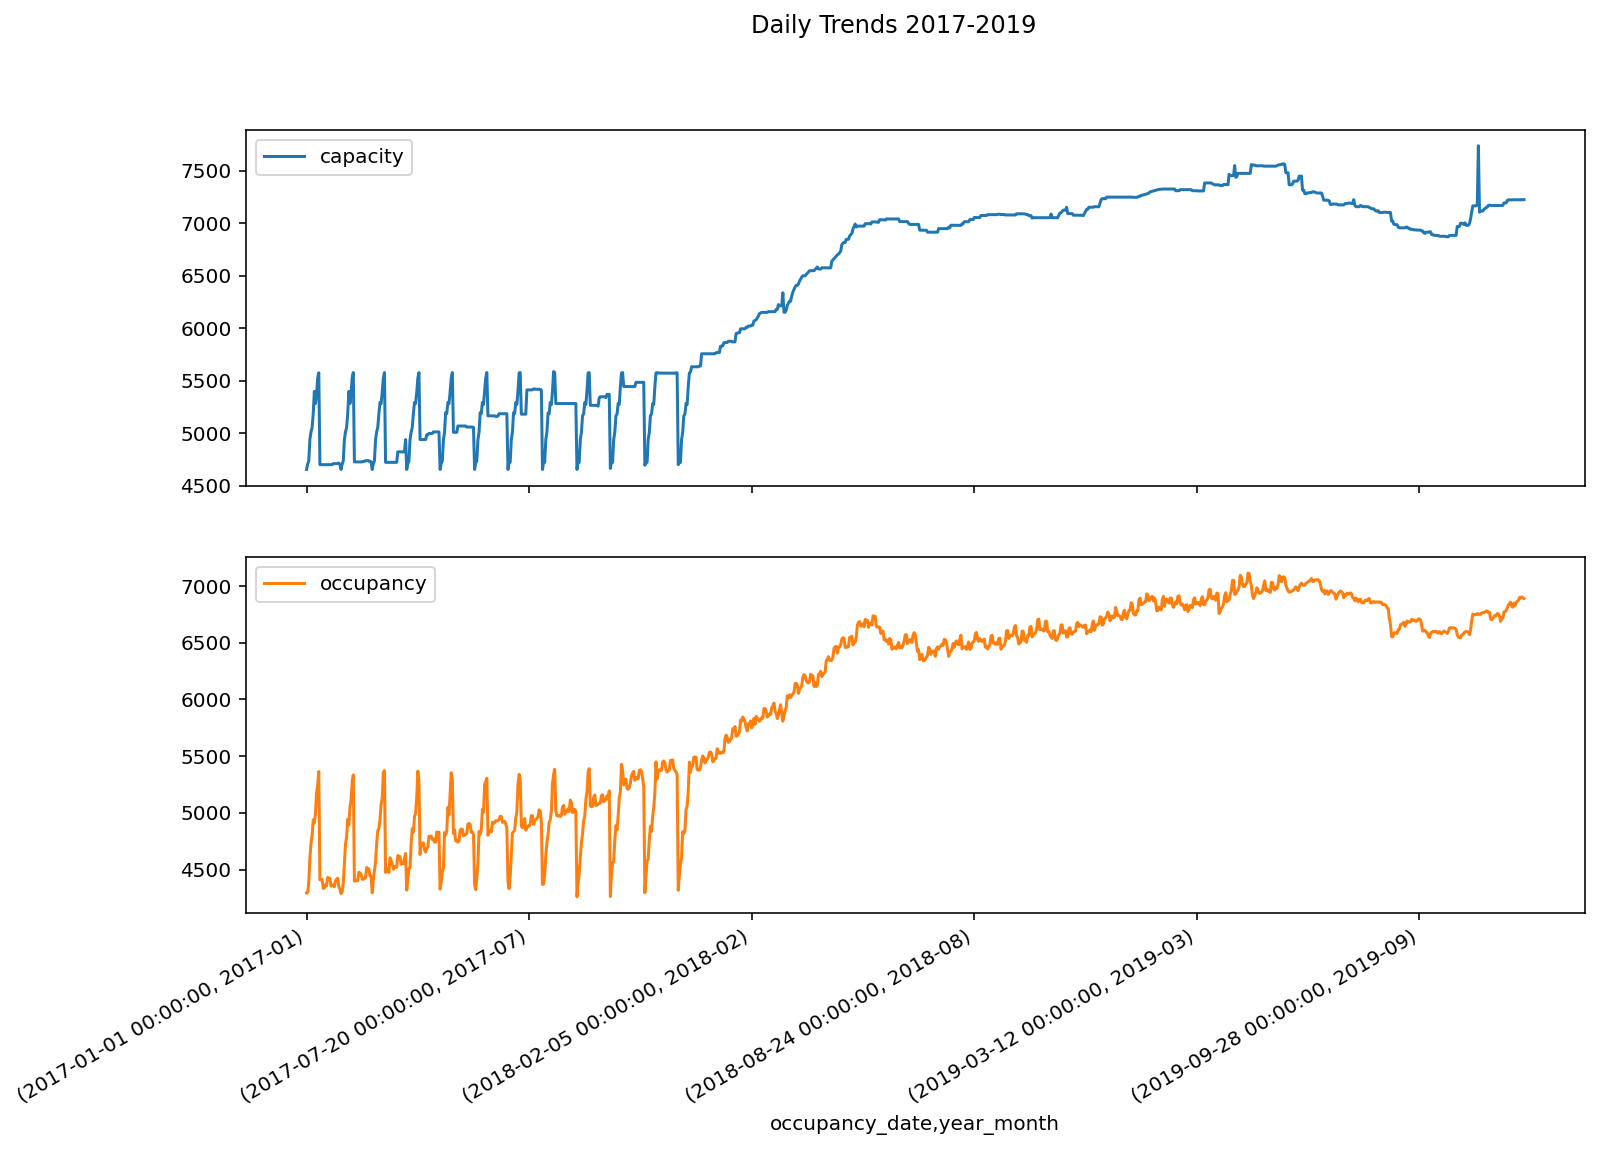

In [7]:
daily_totals_df.plot(subplots=True, figsize=(12,8), title='Daily Trends 2017-2019');

## First Look

#### Check for Nulls ⭕️
- Found in shelter_postal_code and capacity columns.
- CONSIDER MANUALLY PROVIDING POSTAL CODES (IF POSSIBLE)
- CONSIDER REPLACING MISSING CAPACITIES WITH ZEROS

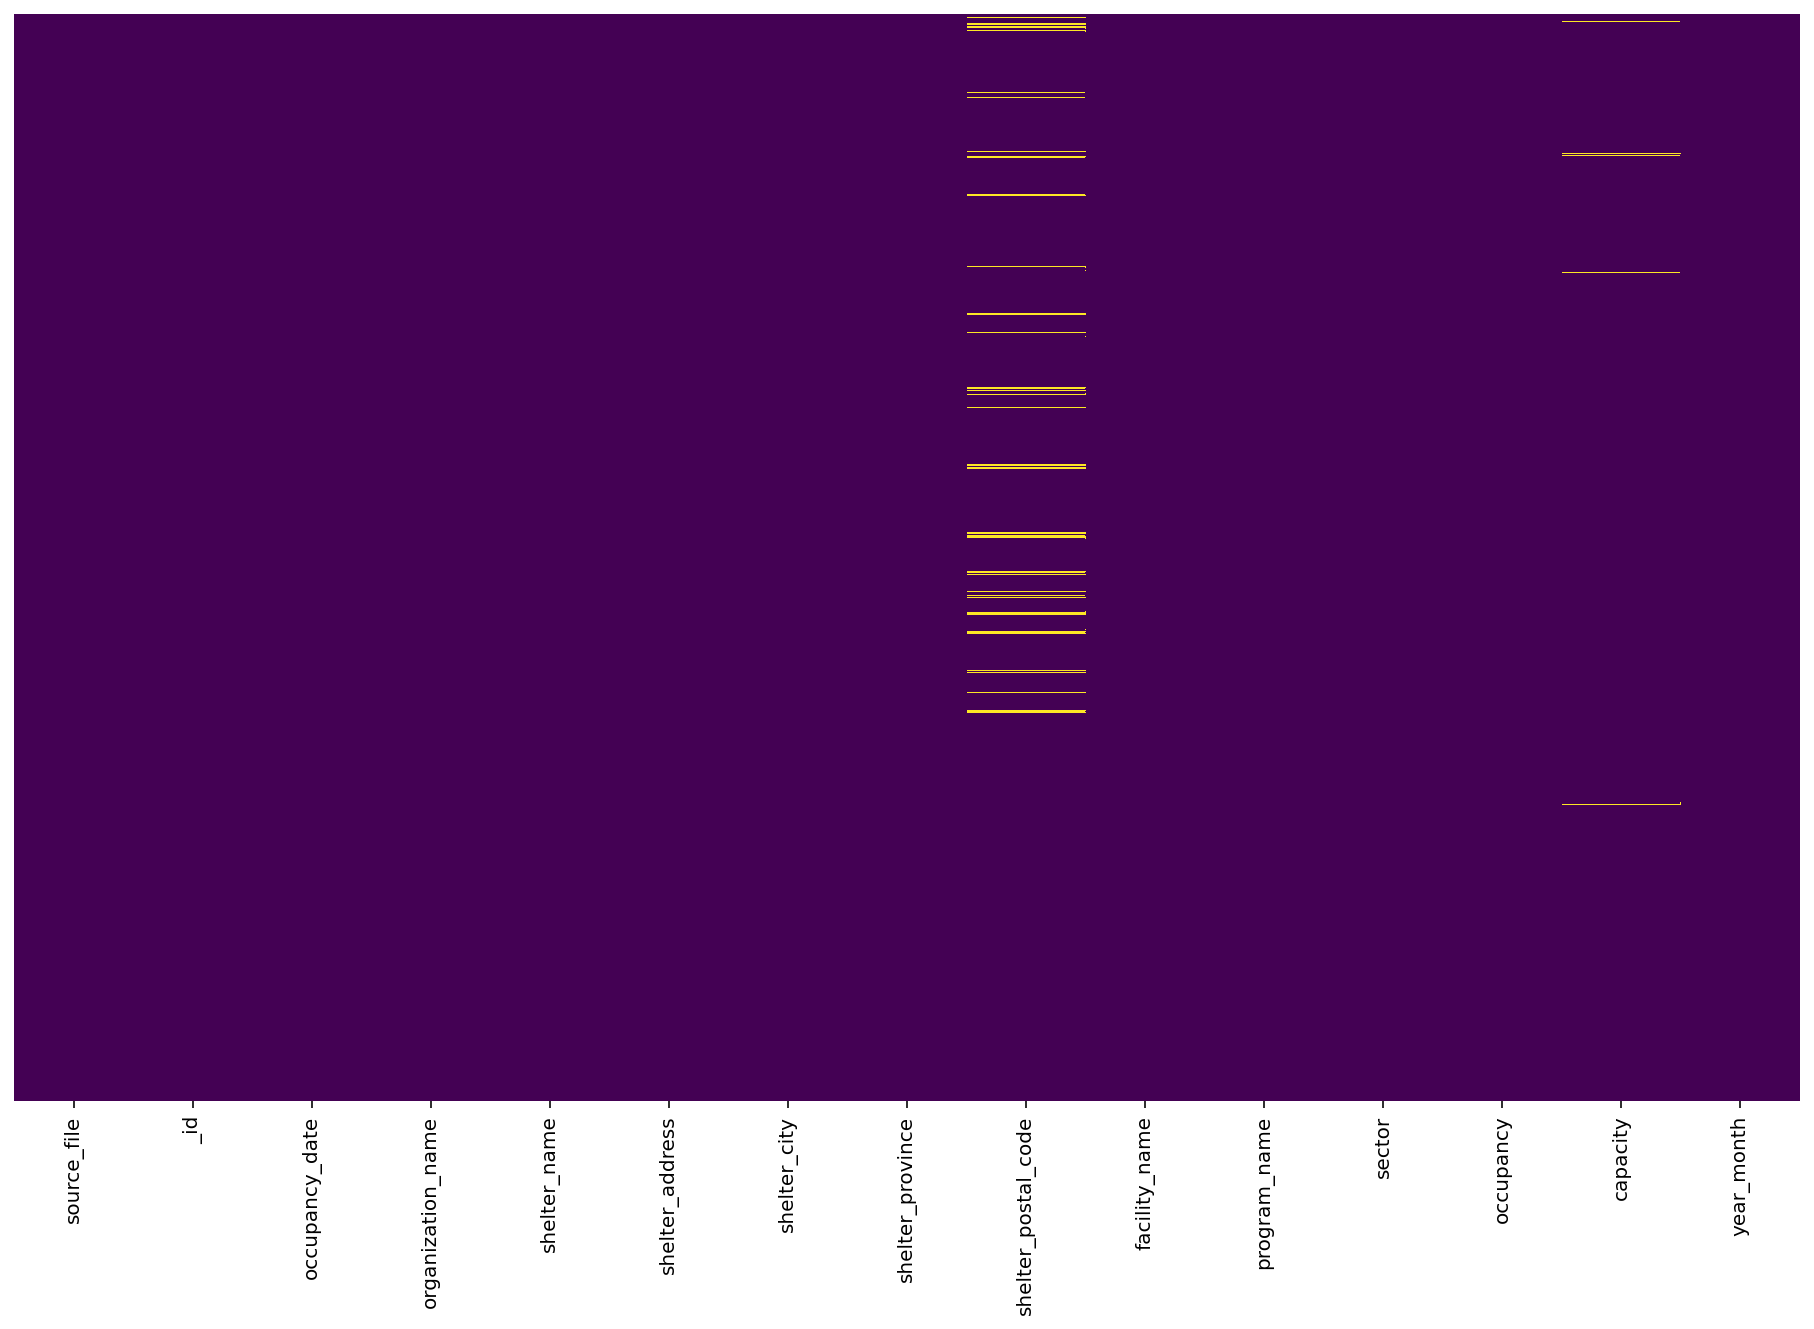

In [8]:
plt.figure(figsize=(16,10))
sns.heatmap(daily_shelter_occupancy.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='viridis');

In [9]:
# Drop records with nulls in capacity column:
print('BEFORE: Capacity column has',len(daily_shelter_occupancy[daily_shelter_occupancy.capacity.isna()]),'nulls.')
daily_shelter_occupancy = daily_shelter_occupancy.dropna(axis=0, subset=['capacity'])
print('AFTER: Capacity column has',len(daily_shelter_occupancy[daily_shelter_occupancy.capacity.isna()]),'nulls.')

BEFORE: Capacity column has 343 nulls.
AFTER: Capacity column has 0 nulls.


#### Check Data Types
# - WHY IS CAPACITY FLOAT64? ⭕️

In [10]:
daily_shelter_occupancy.info()
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)
daily_shelter_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115573 entries, 0 to 115915
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   source_file          115573 non-null  int64         
 1   _id                  115573 non-null  int64         
 2   occupancy_date       115573 non-null  datetime64[ns]
 3   organization_name    115573 non-null  object        
 4   shelter_name         115573 non-null  object        
 5   shelter_address      115573 non-null  object        
 6   shelter_city         115573 non-null  object        
 7   shelter_province     115573 non-null  object        
 8   shelter_postal_code  110079 non-null  object        
 9   facility_name        115573 non-null  object        
 10  program_name         115573 non-null  object        
 11  sector               115573 non-null  object        
 12  occupancy            115573 non-null  int64         
 13  capacity      

## How Many Shelters?
 - 65 shelters (63 after dropping records with null in capacity column)
 - occurrences suggest multiple records per shelter (more than 365*3)

In [11]:
daily_shelter_occupancy.shelter_name.value_counts()

Seaton House                        6827
Family Residence                    6270
Salvation Army - Maxwell Meighen    4380
COSTI Reception Centre              4081
Fort York Residence                 3942
                                    ... 
Second Base Youth Shelter            410
Scarborough Village Residence        375
Kennedy House Youth Shelter          365
YWCA - Beatrice House                219
Sojourn House - Queens Drive         184
Name: shelter_name, Length: 63, dtype: int64

In [13]:
# Sample records for "Seaton House" on 2017-01-01:
filter = (daily_shelter_occupancy.shelter_name=='Seaton House') & (daily_shelter_occupancy.occupancy_date=='2017-01-01')
sample(daily_shelter_occupancy.loc[filter], 5)

KeyError: ignored

## How many programs?
- 155 programs

In [ ]:
daily_shelter_occupancy.program_name.value_counts()[0:500]
len(daily_shelter_occupancy.program_name.value_counts())

## Check / correct Data Types
- occupancy_date corrected during load

# EDA Q&A

## What are the capacity and occupancy trends?
1. Find daily totals at required granularity (overall, by shelter, by program, etc.)
2. Find daily averages by month and year

#### Monthly Average and Totals

In [ ]:
# Plot monthly totals
daily_totals_df.groupby(['year_month']).mean().plot(
    marker='.', figsize=(9,6), ylim=([0,8000]),
    title='Totals by Month, 2017-2019');

In [ ]:
# Plot the daily averages BY MONTH and plot
# (Answers the question, "How does the daily average change from one month to the next?")
daily_totals_df.groupby(['year_month']).mean().plot(
    marker='.', figsize=(9,6), ylim=([0,8000]),
    title='Daily Averages by Month, 2017-2019');

#### Daily Averages and Totals
- Why does 2017 fluctuate each month? (Monthly reporting?)

In [ ]:
daily_totals_df.plot(marker='.', figsize=(15,10), ylim=([0,8000]));
    
#.filter_by({'year-month':'2017-03'})

In [ ]:
#daily_totals_df['occupancy_date']
daily_totals_df['2017-01'].plot(subplots=True, figsize=(12,12));

In [ ]:
daily_totals_df.info()
daily_totals_df.index

In [ ]:
#daily_totals_df[daily_totals_df.index.isin([('2017-01-01', '2017-01')])]#.names
daily_totals_df['year-month']=='2017-01'

In [ ]:
daily_totals_df['2017'].head(30)

In [ ]:
# Plot daily totals
daily_totals_df.plot(subplots=True,
    figsize=(9,6),
    title='Daily Totals, 2017-2019');

In [ ]:
# Plot daily totals
daily_totals_df['2017'].plot(subplots=True,
    figsize=(12,10),
    title='Daily Totals, 2017');

In [11]:
daily_occupancy_totals_df = daily_shelter_occupancy.loc[:,['occupancy_date','occupancy','vacancy']].groupby(['occupancy_date']).sum()
display(daily_occupancy_totals_df.head(3))

daily_occupancy_totals_df.plot(
    figsize=(12,8),
    title = 'Overall Daily Capacity Trend').vlines(
        x='2018-01-01', colors='r',
        ymin=daily_occupancy_totals_df.min(), 
        ymax=daily_occupancy_totals_df.max());

KeyError: ignored

### Which ORGANIZATIONS are the largest by overall capacity?

#### Find top 5 organizations

In [ ]:
# IDENTIFY LIST OF "TOP 5" ORGANIZATIONS BY OVERALL CAPACITY:
#---Sum of capacity by organization_name and date in desc order of capacity for top 5 organizations
org_pivot = daily_shelter_occupancy.pivot_table('capacity','organization_name',aggfunc='sum')
org_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_5_capacity_org_list = list(org_pivot.head(5).index)
display(org_pivot.head(10))
print('\nTop 5 organizations by overall capacity:\n')
top_5_capacity_org_list

#### Filter and reshape data for top 5 organizations

In [ ]:
# Filter main df for top 5 organizations and pivot (one capacity column per shelter)
filter = daily_shelter_occupancy.organization_name.isin(top_5_capacity_org_list)
top_5_orgs_by_capacity_df = daily_shelter_occupancy[filter]
display(top_5_orgs_by_capacity_df.head(3))

#---select columns
top_5_orgs_by_capacity_df = top_5_orgs_by_capacity_df.loc[:,['occupancy_date','organization_name','occupancy']]
display(top_5_orgs_by_capacity_df.head(3))

#---Pivot to one org per column
top_5_orgs_by_capacity_df = top_5_orgs_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['organization_name'],
    values='occupancy',
    aggfunc='sum')
display(top_5_orgs_by_capacity_df.head(3))

#### Plot capacity trends of top 5 organizations

In [ ]:
#-plot with subplots
top_5_orgs_by_capacity_df.plot(subplots=True, 
                               figsize=(12,12), 
                               title='Capacity Trends of Top 5 Organizations');

### Which SHELTERS are the largest by overall capacity?

#### Find top 6 shelters

In [ ]:
# IDENTIFY LIST OF "TOP 6" SHELTERS BY OVERALL CAPACITY:
#---Sum of capacity by shelter_name and date in desc order of capacity for top 6 shelters
shelter_pivot = daily_shelter_occupancy.pivot_table('capacity','shelter_name',aggfunc='sum')
shelter_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_6_shelters_by_capacity_list = list(shelter_pivot.head(6).index)
display(shelter_pivot.head(10))
print('\nTop 6 shelters by overall capacity:\n')
top_6_shelters_by_capacity_list

#### Filter and reshape data for top 6 shelters

In [ ]:
# Filter main df for top 5 organizations and pivot (one capacity column per shelter)
filter = daily_shelter_occupancy.shelter_name.isin(top_6_shelters_by_capacity_list)
top_6_shelters_by_capacity_df = daily_shelter_occupancy[filter]
display(top_6_shelters_by_capacity_df.head(3))

#---select columns
top_6_shelters_by_capacity_df = top_6_shelters_by_capacity_df.loc[:,['occupancy_date','shelter_name','occupancy']]
display(top_6_shelters_by_capacity_df.head(3))

#---Pivot to one org per column
top_6_shelters_by_capacity_df = top_6_shelters_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['shelter_name'],
    values='occupancy',
    aggfunc='sum')
display(top_6_shelters_by_capacity_df.head(3))

#### Plot capacity trends for top 6 shelters

In [ ]:
#-plot with subplots
top_6_shelters_by_capacity_df.plot(subplots=True, figsize=(12,8));
top_6_shelters_by_capacity_df.plot( figsize=(12,8));

### Which PROGRAMS are the largest by overall capacity?

#### Find top 6 PROGRAMS

In [ ]:
# IDENTIFY NAMES OF "TOP 6" PROGRAMS BY OVERALL CAPACITY (LIST!):
#---Sum of capacity by program_name and date in desc order of capacity for top 6 shelters
program_pivot = daily_shelter_occupancy.pivot_table('capacity','program_name',aggfunc='sum')
program_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_6_programs_by_capacity_list = list(program_pivot.head(6).index)
display(program_pivot.head(10))
print('\nTop 6 programs by overall capacity:\n')
top_6_programs_by_capacity_list

#### Filter and reshape data for top 6 PROGRAMS

In [ ]:
# Filter main df for top 6 PROGRAMS and pivot (one capacity column per PROGRAM)
#---select rows and columns
filter = daily_shelter_occupancy.program_name.isin(top_6_programs_by_capacity_list)
top_6_programs_by_capacity_df = daily_shelter_occupancy.loc[filter,
                                                                  ['occupancy_date','program_name','occupancy']]
display(top_6_programs_by_capacity_df.head())

#---Pivot
top_6_programs_by_capacity_df = top_6_programs_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['program_name'],
    values='occupancy',
    aggfunc='sum')

#### Plot capacity trends for top 6 PROGRAMS

In [ ]:
#-plot with subplots
display(top_6_programs_by_capacity_df)
top_6_programs_by_capacity_df.plot(subplots=True, figsize=(12,12));

In [ ]:
# Filter main df for Top 10 and pivot (one capacity column per shelter)
filter = daily_shelter_occupancy['shelter_name'].isin(top_10_capacity_shelter_list)
top_10_daily_shelter_occupancy = daily_shelter_occupancy[filter]
top_10_daily_shelter_occupancy

#---select columns
top_10_daily_shelter_occupancy = top_10_daily_shelter_occupancy.loc[:,['occupancy_date','shelter_name','occupancy']]

#---Pivot
top_10_daily_shelter_occupancy = top_10_daily_shelter_occupancy.pivot_table(
    index=['occupancy_date'], 
    columns=['shelter_name'],
    values='occupancy',
    aggfunc='sum')

#-plot with subplots
top_10_daily_shelter_occupancy.plot(figsize=(15,10));
#shelter_pivot.plot(subplots=True)




### What are the overall capacity trends for the ten largest shelters?

In [ ]:
filter = daily_shelter_occupancy['shelter_name'].isin(top_10_capacity_shelter_list)
top_10_daily_shelter_occupancy = daily_shelter_occupancy[filter]
top_10_daily_shelter_occupancy[['year_month', 'capacity']].groupby(['year_month']).sum().plot();

### What are the largest programs by capacity?
- Each shelter runs multiple programs and measures capacity, etc. by program.